In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dog_epidemic.Utils as utils
from datetime import date
import numpy as np
import shapely
from shapely import Point
from shapely import Polygon
import random
import geopandas as gp

In [3]:
nyc_dogs = pd.read_csv('NYC_Dog_Licensing_Dataset_20250202.csv', parse_dates=['AnimalBirthYear', 'LicenseIssuedDate', 'LicenseExpiredDate'])
nyc_dogs['ID'] = nyc_dogs.index

nyc_zips = gp.read_file('NYC_ZIP_CODES/geo_export_21df9e0c-f12a-46dc-ab61-8ef1dccb55c3.shp')


In [4]:
print("Unknown dog breeds:", nyc_dogs.loc[nyc_dogs['BreedName'] == "Unknown"].shape[0])
print("Name not provided:", nyc_dogs.loc[nyc_dogs['AnimalName'] == "NAME NOT PROVIDED"].shape[0])

utils.recode_missing(nyc_dogs, ['BreedName'], "Unknown")
utils.recode_missing(nyc_dogs, ['AnimalName'], "NAME NOT PROVIDED")
utils.recode_missing(nyc_dogs, ['AnimalName'], "UNKNOWN")
nyc_dogs['AnimalBirthYear'] = pd.to_numeric(nyc_dogs['AnimalBirthYear'], errors='coerce')
nyc_dogs['IssueYear'] = nyc_dogs['LicenseIssuedDate'].dt.year
nyc_dogs['ExpireYear'] = nyc_dogs['LicenseExpiredDate'].dt.year

print("Missing BreedName:", nyc_dogs[nyc_dogs['BreedName'].isnull()].shape[0])
print("Missing AnimalName:", nyc_dogs[nyc_dogs['AnimalName'].isnull()].shape[0])
print("Missing ZipCode:", nyc_dogs[nyc_dogs['ZipCode'].isnull()].shape[0])
print("Missing AnimalGender:", nyc_dogs[nyc_dogs['AnimalGender'].isnull()].shape[0])
print("Missing AnimalBirthYear:", nyc_dogs[nyc_dogs['AnimalBirthYear'].isnull()].shape[0])
print("Missing LicenseIssuedDate:", nyc_dogs[nyc_dogs['LicenseIssuedDate'].isnull()].shape[0])
print("Missing LicenseExpiredDate:", nyc_dogs[nyc_dogs['LicenseExpiredDate'].isnull()].shape[0])


Unknown dog breeds: 55254
Name not provided: 7316


/Users/emmagray/Desktop/spatial_canine_epidemic/dog_epidemic/Utils.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].replace(missing, pandas.NA, inplace=True)


Missing BreedName: 55254
Missing AnimalName: 23673
Missing ZipCode: 9
Missing AnimalGender: 21
Missing AnimalBirthYear: 30
Missing LicenseIssuedDate: 0
Missing LicenseExpiredDate: 82


In [6]:
nyc_dogs['AgeAtIssue'] = nyc_dogs.apply(utils.age_at, axis = 1, birthyear='AnimalBirthYear', year='IssueYear')
nyc_dogs['AgeAtExpire'] = nyc_dogs.apply(utils.age_at, axis = 1, birthyear='AnimalBirthYear', year='ExpireYear')
nyc_dogs['CurrentYear'] = 2024
nyc_dogs['CurrentAge'] = nyc_dogs.apply(utils.age_at, axis= 1, birthyear = 'AnimalBirthYear', year='CurrentYear')


Dogs cannot have negative ages
Dogs cannot have negative ages
Dogs cannot have negative ages
Dogs cannot have negative ages
Dogs cannot have negative ages
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is implausible
Dog older than 30 years is

In [9]:
# Remove dogs whose licenses have expired before the last extraction year (2023)
current_nyc_dogs = nyc_dogs[nyc_dogs["ExpireYear"] >= 2023]
print(nyc_dogs.shape[0])
print(current_nyc_dogs.shape[0])

# Remove dogs that are older then 2 in 2024
puppies_nyc = current_nyc_dogs[current_nyc_dogs['CurrentAge'] < 2]
print(puppies_nyc.shape[0])

616890
136736
5334


In [17]:
nyc_zips['ZipCode'] = nyc_zips['modzcta'].astype('float64')

nyc_puppies_with_zip = puppies_nyc.join(nyc_zips.set_index('ZipCode'), on = 'ZipCode', how = 'left', sort = True)
nyc_puppies_with_zip.dropna(inplace=True)
nyc_puppies_with_zip.reset_index()
nyc_puppies_with_zip = gp.GeoDataFrame(nyc_puppies_with_zip)
print(nyc_puppies_with_zip['geometry'])


582269    POLYGON ((-73.98774 40.74407, -73.98819 40.743...
583996    POLYGON ((-73.98774 40.74407, -73.98819 40.743...
587310    POLYGON ((-73.98774 40.74407, -73.98819 40.743...
587999    POLYGON ((-73.98774 40.74407, -73.98819 40.743...
590297    POLYGON ((-73.98774 40.74407, -73.98819 40.743...
                                ...                        
597155    MULTIPOLYGON (((-73.8201 40.587, -73.81943 40....
601414    MULTIPOLYGON (((-73.8201 40.587, -73.81943 40....
616049    MULTIPOLYGON (((-73.8201 40.587, -73.81943 40....
609023    POLYGON ((-73.86496 40.56663, -73.86558 40.567...
614514    POLYGON ((-73.86496 40.56663, -73.86558 40.567...
Name: geometry, Length: 3864, dtype: geometry


In [18]:

nyc_puppies_with_zip['locations'] = pd.DataFrame(nyc_puppies_with_zip.apply(utils.pick_location, axis=1, shape='geometry'))


<Axes: >

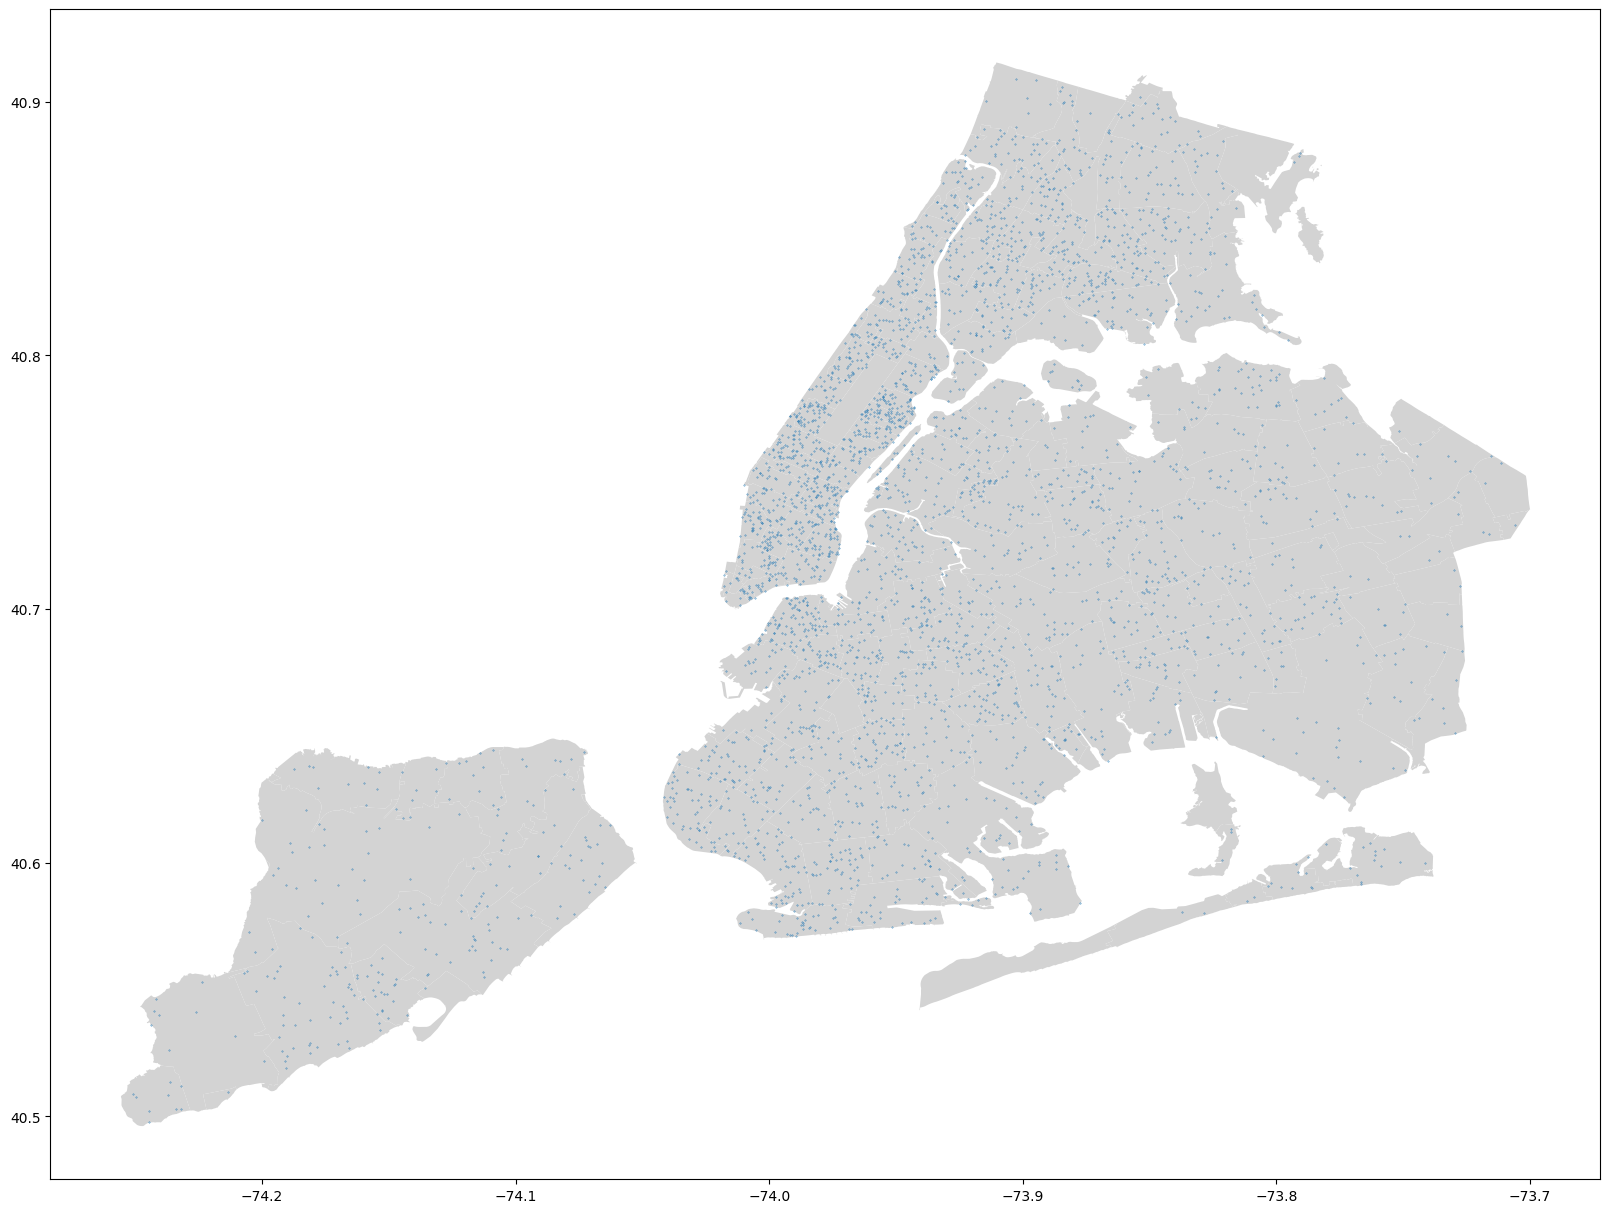

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))
nyc_zips['geometry'].plot(ax = ax, color = 'lightgray')
nyc_puppies_with_zip['locations'].plot(ax = ax, markersize = 0.09)

In [22]:
# Save data
nyc_puppies_with_zip.to_parquet('CurrentNYCPuppies.parquet')
